# Duomenų nuskaitymas ir paruošimas

In [1]:
#visi paketai
import csv
import numpy as np
import os
from pyspark.sql.types import IntegerType, DoubleType, StructField, StructType
from pyspark.mllib.stat import Statistics 
from math import sqrt 
import pandas as pd
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, stddev_samp
from pyspark.mllib.clustering import KMeans
from pyspark.mllib.linalg import DenseVector
import ggplot as gg
from pyspark.sql import Row
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel
import matplotlib.pyplot as plt

from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark import SparkContext, SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



from pyspark import ml
from pyspark import mllib
import pyspark.ml.feature
import pyspark.ml.clustering
import pyspark.ml.classification
import pyspark.ml.evaluation
import pyspark.mllib.feature
import pyspark.mllib.clustering
import ggplot as gg
import pandas as pd

## Importavimas ir agregacija

In [12]:
ca1DF = (
    sqlContext.read.load("../../Data/customer_usage_00006.csv",
                         format="com.databricks.spark.csv",
                         header=True, inferSchema=True, delimiter=",")
    .rdd.toDF()
).cache()

In [13]:
ca1DF.registerTempTable("customer_usage")
dateCols = ["year", "month"]
idCols = ["user_account_id"]
binaryCols = [
    "user_intake",
    "user_has_outgoing_calls", "user_has_outgoing_sms", 
    "user_use_gprs", "user_does_reload"
]
categoricalCols = dateCols + binaryCols + idCols
continuousCols = [c for c in ca1DF.columns if c not in categoricalCols]
sqlExprsMeanCols = ["AVG({0}) AS {0}".format(c) for c in continuousCols]
sqlExprsBinaryCols = ["MAX({0}) AS {0}".format(c) for c in binaryCols]
sqlExprsDateCols = ["COUNT(*) AS n_months"]
sqlSelectExprs = sqlExprsMeanCols + sqlExprsBinaryCols + sqlExprsDateCols
sqlSelect = ", ".join(sqlSelectExprs)
sqlSelect

'AVG(user_lifetime) AS user_lifetime, AVG(user_no_outgoing_activity_in_days) AS user_no_outgoing_activity_in_days, AVG(user_account_balance_last) AS user_account_balance_last, AVG(user_spendings) AS user_spendings, AVG(reloads_inactive_days) AS reloads_inactive_days, AVG(reloads_count) AS reloads_count, AVG(reloads_sum) AS reloads_sum, AVG(calls_outgoing_count) AS calls_outgoing_count, AVG(calls_outgoing_spendings) AS calls_outgoing_spendings, AVG(calls_outgoing_duration) AS calls_outgoing_duration, AVG(calls_outgoing_spendings_max) AS calls_outgoing_spendings_max, AVG(calls_outgoing_duration_max) AS calls_outgoing_duration_max, AVG(calls_outgoing_inactive_days) AS calls_outgoing_inactive_days, AVG(calls_outgoing_to_onnet_count) AS calls_outgoing_to_onnet_count, AVG(calls_outgoing_to_onnet_spendings) AS calls_outgoing_to_onnet_spendings, AVG(calls_outgoing_to_onnet_duration) AS calls_outgoing_to_onnet_duration, AVG(calls_outgoing_to_onnet_inactive_days) AS calls_outgoing_to_onnet_inact

In [15]:
#agreguotas dataframe
ca1DF = sqlContext.sql("""
    SELECT user_account_id, {}
    FROM customer_usage
    GROUP BY user_account_id
""".format(sqlSelect))
ca1DF.first()

Row(user_account_id=4231, user_lifetime=951.0, user_no_outgoing_activity_in_days=1.3333333333333333, user_account_balance_last=27.546666666666667, user_spendings=6.45, reloads_inactive_days=22.0, reloads_count=1.0, reloads_sum=12.013333333333334, calls_outgoing_count=46.333333333333336, calls_outgoing_spendings=6.45, calls_outgoing_duration=47.150000000000006, calls_outgoing_spendings_max=1.3233333333333333, calls_outgoing_duration_max=8.81, calls_outgoing_inactive_days=1.3333333333333333, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=1.3333333333333333, calls_outgoing_to_offnet_count=31.666666666666668, calls_outgoing_to_offnet_spendings=6.400000000000001, calls_outgoing_to_offnet_duration=42.656666666666666, calls_outgoing_to_offnet_inactive_days=1.3333333333333333, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_duration=0.0, ca

In [ ]:
#Agreguotu duomenu issaugojimas
ca1DF.write.format("com.databricks.spark.csv").save("output/aggregated_customer_usage")

In [17]:

with open("output/header__aggregated_customer_usage.txt", "w") as f:
    f.write(",".join(ca1DF.columns))
with open("output/header__aggregated_customer_usage.txt") as f:
    columns = f.read().split(",")
with open("output/columns_continuous__agg_usage.txt", "w") as f:
    f.write(",".join(continuousCols))
with open("output/columns_binary__agg_usage.txt", "w") as f:
    f.write(",".join(continuousCols))
with open("output/columns_ids__agg_usage.txt", "w") as f:
    f.write(",".join(idCols))
with open("output/columns_misc__agg_usage.txt", "w") as f:
    f.write("n_months")

## Agreguoti duomenys

In [18]:
ca1DF = (
    sqlContext.read.format("com.databricks.spark.csv")
    .options(inferSchema=True, header=False)
    .load("output/aggregated_customer_usage/")
    .rdd
    .toDF(columns)  
)

In [19]:
ca1DF.take(1)

[Row(user_account_id=578, user_lifetime=967.0, user_no_outgoing_activity_in_days=10.333333333333334, user_account_balance_last=11.35, user_spendings=2.18, reloads_inactive_days=42.0, reloads_count=0.3333333333333333, reloads_sum=3.3333333333333335, calls_outgoing_count=8.666666666666666, calls_outgoing_spendings=0.0, calls_outgoing_duration=2.98, calls_outgoing_spendings_max=0.0, calls_outgoing_duration_max=0.8733333333333334, calls_outgoing_inactive_days=13.333333333333334, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=13.333333333333334, calls_outgoing_to_offnet_count=0.0, calls_outgoing_to_offnet_spendings=0.0, calls_outgoing_to_offnet_duration=0.0, calls_outgoing_to_offnet_inactive_days=13.333333333333334, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_duration=0.0, calls_outgoing_to_abroad_inactive_days=13.333333333333334, sm

In [23]:
RDDmat = (
    sqlContext.read.format("com.databricks.spark.csv")
    .options(inferSchema=True, header=False)
    .load("output/aggregated_customer_usage/")
    .rdd)

In [27]:
ca1DFtemp=ca1DF#kitaip sugadina ca1DF
RDDmat=ca1DFtemp.rdd.map(list)
#RDDmat=ca1DFtemp.rdd
RDDmat.take(1)

[[578,
  967.0,
  10.333333333333334,
  11.35,
  2.18,
  42.0,
  0.3333333333333333,
  3.3333333333333335,
  8.666666666666666,
  0.0,
  2.98,
  0.0,
  0.8733333333333334,
  13.333333333333334,
  0.0,
  0.0,
  0.0,
  13.333333333333334,
  0.0,
  0.0,
  0.0,
  13.333333333333334,
  0.0,
  0.0,
  0.0,
  13.333333333333334,
  28.0,
  2.18,
  0.11,
  12.666666666666666,
  15.333333333333334,
  0.92,
  12.666666666666666,
  0.0,
  0.0,
  12.666666666666666,
  7.666666666666667,
  0.71,
  12.666666666666666,
  5.666666666666667,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1307.0,
  1.3333333333333333,
  7.333333333333333,
  7.173333333333333,
  0.0,
  0.0,
  0.62,
  59.0,
  28.0,
  0.0,
  24.333333333333332,
  0.0,
  0,
  1,
  1,
  0,
  1,
  3]]

In [175]:
#Nuskaityti kaip DF:
#ca1DF = (
#    sqlContext.read.load("../../Data/customer_usage_00006.csv",
#                         format="com.databricks.spark.csv",
#                         header=True, inferSchema=True, delimiter=",")
#    .rdd.toDF()
#).cache()

Duomenų matricos formatas

# Duomenų statistika

In [29]:
summary = Statistics.colStats(RDDmat)

In [30]:
summaryDf=ca1DF.describe()

In [31]:
pd.set_option('display.max_rows', 66)
summaryDf.toPandas().T

0                    1  \
summary                                     count                 mean   
user_account_id                             43291    594686.8309117368   
user_lifetime                               43291   3790.0030144833804   
user_no_outgoing_activity_in_days           43291    40.35209781863819   
user_account_balance_last                   43291    9.772247041340387   
user_spendings                              43291    6.629490155767554   
reloads_inactive_days                       43291   362.94703287057376   
reloads_count                               43291     0.87981335612483   
reloads_sum                                 43291     7.08398801136495   
calls_outgoing_count                        43291    34.25936876795024   
calls_outgoing_spendings                    43291    4.556243291523255   
calls_outgoing_duration                     43291   30.723694339855122   
calls_outgoing_spendings_max                43291   0.8566388702809666   
calls_outgoing_duration_max                 43291     4.66755361006522   
calls_outgoing_inactive_days                43291   170.14803692838382   
calls_outgoing_to_onnet_count               43291   0.4427902643351582   
calls_outgoing_to_onnet_spendings           43291  0.18616082634573788   
calls_outgoing_to_onnet_duration            43291   0.5587639463167864   
calls_outgoing_to_onnet_inactive_days       43291   170.14803692838382   
calls_outgoing_to_offnet_count              43291   15.008585310264639   
calls_outgoing_to_offnet_spendings          43291   2.7062605776412347   
calls_outgoing_to_offnet_duration           43291    19.56076455460334   
calls_outgoing_to_offnet_inactive_days      43291   170.14803692838382   
calls_outgoing_to_abroad_count              43291    2.107077683583192   
calls_outgoing_to_abroad_spendings          43291   0.3576052759234019   
calls_outgoing_to_abroad_duration           43291   1.5913454297660017   
calls_outgoing_to_abroad_inactive_days      43291   170.14803692838382   
sms_outgoing_count                          43291   34.414874531272844   
sms_outgoing_spendings                      43291   1.8698978232581058   
sms_outgoing_spendings_max                  43291  0.08734783211291029   
sms_outgoing_inactive_days                  43291   403.59814203106123   
sms_outgoing_to_onnet_count                 43291   2.4184742017201426   
sms_outgoing_to_onnet_spendings             43291  0.10981843801251992   
sms_outgoing_to_onnet_inactive_days         43291   403.59814203106123   
sms_outgoing_to_offnet_count                43291    20.95637276416193   
sms_outgoing_to_offnet_spendings            43291   1.2221408606869784   
sms_outgoing_to_offnet_inactive_days        43291   403.59814203106123   
sms_outgoing_to_abroad_count                43291   1.6459233250945164   
sms_outgoing_to_abroad_spendings            43291  0.17531188160741656   
sms_outgoing_to_abroad_inactive_days        43291   403.59814203106123   
sms_incoming_count                          43291    8.958447868302109   
sms_incoming_spendings                      43291   0.1289286456769306   
sms_incoming_from_abroad_count              43291    1.311923956480562   
sms_incoming_from_abroad_spendings          43291  0.01298576301463738   
gprs_session_count                          43291    9.069825906847461   
gprs_usage                                  43291   2.8053342496130838   
gprs_spendings                              43291  0.20335296789940938   
gprs_inactive_days                          43291   1209.3037197877939   
last_100_reloads_count                      43291   3.4940942305175064   
last_100_reloads_sum                        43291    21.56783307615902   
last_100_calls_outgoing_duration            43291    96.10454567154065   
last_100_calls_outgoing_to_onnet_duration   43291   1.3531294033401866   
last_100_calls_outgoing_to_offnet_duration  43291    63.27620587035027   
last_100_calls_outgoing_to_abroad_duration  43291   

In [32]:
def nenuliai(eil):
    print ("Nenuliunių elementų eilutėje ",eil,": ",summary.numNonzeros()[eil])
    print ()
    return

In [33]:
nenuliai(0) #Visi elementai = 2016
nenuliai(20) #Išėjusių skambučių maksimalios trukmės

Nenuliunių elementų eilutėje  0 :  43291.0

Nenuliunių elementų eilutėje  20 :  31023.0



## Stulpelių koreliacija

In [34]:
corrMatrixP = Statistics.corr(RDDmat, method="pearson")

In [35]:
#Panasus rezultatai
#corrMatrixS = Statistics.corr(dataVector, method="spearman")

In [36]:
pd.set_option('display.max_columns', 65)
pd.set_option('display.max_rows', 10)

colmNames = ca1DF.columns
corrDfP = pd.DataFrame(corrMatrixP, index=colmNames, columns=colmNames)
#corrDfS = pd.DataFrame(corrMatrixS, index=colmNames, columns=colmNames)

In [37]:
#corrDfS

In [38]:
corrDfP

user_account_id  user_lifetime  \
user_account_id                           1.000000       0.460269   
user_lifetime                             0.460269       1.000000   
user_no_outgoing_activity_in_days         0.075237       0.299232   
user_account_balance_last                -0.174939      -0.221810   
user_spendings                           -0.087456      -0.235474   
...                                            ...            ...   
user_has_outgoing_calls                  -0.426000      -0.640713   
user_has_outgoing_sms                    -0.348733      -0.596039   
user_use_gprs                            -0.012963      -0.113551   
user_does_reload                          0.061811       0.030924   
n_months                                 -0.536624      -0.719624   

                                   user_no_outgoing_activity_in_days  \
user_account_id                                             0.075237   
user_lifetime                                               0.299232   
user_no_outgoing_activity_in_days                           1.000000   
user_account_balance_last                                  -0.088573   
user_spendings                                             -0.107168   
...                                                              ...   
user_has_outgoing_calls                                     0.057946   
user_has_outgoing_sms                                      -0.219191   
user_use_gprs                                              -0.051877   
user_does_reload                                           -0.234586   
n_months                                                    0.085558   

                                   user_account_balance_last  user_spendings  \
user_account_id                                    -0.174939       -0.087456   
user_lifetime                                      -0.221810       -0.235474   
user_no_outgoing_activity_in_days                  -0.088573       -0.107168   
user_account_balance_last                           1.000000        0.158154   
user_spendings                                      0.158154        1.000000   
...                                                      ...             ...   
user_has_outgoing_calls                             0.163815        0.170868   
user_has_outgoing_sms                               0.183737        0.297761   
user_use_gprs                                       0.046281        0.194749   
user_does_reload                                    0.027289        0.277023   
n_months                                            0.181747        0.173041   

                                   reloads_inactive_days  reloads_count  \
user_account_id                                -0.095005       0.027763   
user_lifetime                                  -0.015631      -0.053527   
user_no_outgoing_activity_in_days               0.351910      -0.142046   
user_account_balance_last                      -0.031529      -0.018462   
user_spendings                                 -0.301018       0.702887   
...                                                  ...            ...   
user_has_outgoing_calls                         0.200999      -0.027072   
user_has_outgoing_sms                          -0.270512       0.201011   
user_use_gprs                                  -0.118559       0.160882   
user_does_reload                               -0.870044       0.443900   
n_months                                        0.267303      -0.073507   

                                   reloads_sum  calls_outgoing_count  \
user_account_id                      -0.063027             -0.071167   
user_lifetime                        -0.216740             -0.256572   
user_no_outgoing_activity_in_days    -0.096733             -0.117253   
user_account_balance_last             0.209207              0.057416   
user_spendings                        0.930366              0.648644   
...                                        ... 

Sunjungiame/ištriname koreliuojančius kintamuosius, tarp kurių koreliacija yra >90%. Koreliuoja 2 stulpeliai, tai vieną iš jų ištriname.

In [39]:
pd.set_option('display.max_columns', 65)
pd.set_option('display.max_rows', 65)
highlyCorrelatedDf = (abs(corrDfP) > .90) & (corrDfP < 1.0)
correlatedVarsIndex = (highlyCorrelatedDf==True).any()
correlatedVarNames = correlatedVarsIndex[correlatedVarsIndex==True].index
highlyCorrelatedDf.loc[correlatedVarNames,correlatedVarNames]

user_spendings reloads_sum  \
user_spendings                                      False        True   
reloads_sum                                          True       False   
calls_outgoing_duration                             False       False   
calls_outgoing_to_onnet_spendings                   False       False   
calls_outgoing_to_onnet_duration                    False       False   
calls_outgoing_to_offnet_duration                   False       False   
calls_outgoing_to_abroad_duration                   False       False   
sms_outgoing_count                                  False       False   
sms_outgoing_inactive_days                          False       False   
sms_outgoing_to_onnet_count                         False       False   
sms_outgoing_to_onnet_inactive_days                 False       False   
sms_outgoing_to_offnet_count                        False       False   
sms_outgoing_to_offnet_spendings                    False       False   
sms_outgoing_to_offnet_inactive_days                False       False   
sms_outgoing_to_abroad_inactive_days                False       False   
gprs_inactive_days                                  False       False   
last_100_reloads_sum                                 True        True   
last_100_calls_outgoing_duration                    False       False   
last_100_calls_outgoing_to_onnet_duration           False       False   
last_100_calls_outgoing_to_offnet_duration          False       False   
last_100_calls_outgoing_to_abroad_duration          False       False   
last_100_sms_outgoing_count                         False       False   
last_100_sms_outgoing_to_onnet_count                False       False   
last_100_sms_outgoing_to_offnet_count               False       False   
user_has_outgoing_sms                               False       False   
user_use_gprs                                       False       False   

                                           calls_outgoing_duration  \
user_spendings                                               False   
reloads_sum                                                  False   
calls_outgoing_duration                                      False   
calls_outgoing_to_onnet_spendings                            False   
calls_outgoing_to_onnet_duration                             False   
calls_outgoing_to_offnet_duration                            False   
calls_outgoing_to_abroad_duration                            False   
sms_outgoing_count                                           False   
sms_outgoing_inactive_days                                   False   
sms_outgoing_to_onnet_count                                  False   
sms_outgoing_to_onnet_inactive_days                          False   
sms_outgoing_to_offnet_count                                 False   
sms_outgoing_to_offnet_spendings                             False   
sms_outgoing_to_offnet_inactive_days                         False   
sms_outgoing_to_abroad_inactive_days                         False   
gprs_inactive_days                                           False   
last_100_reloads_sum                                         False   
last_100_calls_outgoing_duration                              True   
last_100_calls_outgoing_to_onnet_duration                    False   
last_100_calls_outgoing_to_offnet_duration                   False   
last_100_calls_outgoing_to_abroad_duration                   False   
last_100_sms_outgoing_count                                  False   
last_100_sms_outgoing_to_onnet_count                         False   
last_100_sms_outgoing_to_offnet_count                        False   
user_has_outgoing_sms                                        False   
user_use_gprs                                                False   

                                           calls_outgoing_to_onnet_spendings  \
user_spendings                                                         False   
reloads_sum         

Ištrinu koreliuojančias daugiau nei 90% reikšmes (palieku po 1 iš koreliuojančios stulpelių grupės)

In [96]:
#be 90%+ koreliuojanciu reiksmiu
df=ca1DF
df=df.drop('user_use_gprs')
df=df.drop('user_has_outgoing_sms')
df=df.drop('last_100_sms_outgoing_to_offnet_count')
df=df.drop('last_100_sms_outgoing_to_onnet_count')
df=df.drop('last_100_sms_outgoing_count')
df=df.drop('last_100_calls_outgoing_to_abroad_duration')
df=df.drop('last_100_calls_outgoing_to_offnet_duration')
df=df.drop('last_100_calls_outgoing_to_onnet_duration')
df=df.drop('last_100_calls_outgoing_duration')
df=df.drop('sms_outgoing_to_offnet_inactive_days')
df=df.drop('calls_outgoing_to_offnet_duration')
df=df.drop('calls_outgoing_duration')
#df.take(2)

In [7]:
#be kokybiniu reiksmiu [0, 1]
df1=df
df1=df1.drop('user_intake')
df1=df1.drop('user_has_outgoing_calls')
df1=df1.drop('user_has_outgoing_sms')
df1=df1.drop('user_use_gprs')
df1=df1.drop('user_does_reload')
df1=df1.drop('reloads_count')
df1=df1.drop('n_months')

In [14]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
#df1.take(1) #pirma eilute
#df1.show(1) #negraziai brezia
df1.toPandas().transpose()

0            1            2      \
user_account_id                         578.000000  1178.000000  3578.000000   
user_lifetime                           967.000000   972.000000   851.000000   
user_no_outgoing_activity_in_days        10.333333     7.000000     0.666667   
user_account_balance_last                11.350000     5.376667     8.386667   
user_spendings                            2.180000     0.433333     8.603333   
...                                            ...          ...          ...   
gprs_inactive_days                     1307.000000  1307.000000  1307.000000   
last_100_reloads_count                    1.333333     1.000000     2.666667   
last_100_reloads_sum                      7.333333     6.000000    24.500000   
last_100_sms_outgoing_to_abroad_count    24.333333     3.333333    10.000000   
last_100_gprs_usage                       0.000000     0.000000     0.000000   

                                             3            4        ...      \
user_account_id                        3778.000000  8778.000000    ...       
user_lifetime                           915.000000   966.000000    ...       
user_no_outgoing_activity_in_days         0.333333     2.666667    ...       
user_account_balance_last                 6.233333     9.563333    ...       
user_spendings                            8.986667     1.000000    ...       
...                                            ...          ...    ...       
gprs_inactive_days                     1307.000000   479.000000    ...       
last_100_reloads_count                    3.333333     0.333333    ...       
last_100_reloads_sum                     23.335000     4.000000    ...       
last_100_sms_outgoing_to_abroad_count     0.000000     0.000000    ...       
last_100_gprs_usage                       0.000000     0.423333    ...       

                                           43286      43287      43288  \
user_account_id                        1195658.0  1195858.0  1196058.0   
user_lifetime                            15947.0    15947.0    15947.0   
user_no_outgoing_activity_in_days            1.0        1.0        1.0   
user_account_balance_last                    0.0        0.0        0.0   
user_spendings                               0.0        0.0        0.0   
...                                          ...        ...        ...   
gprs_inactive_days                        1338.0     1338.0     1338.0   
last_100_reloads_count                       1.0        1.0        1.0   
last_100_reloads_sum                         0.0        0.0        0.0   
last_100_sms_outgoing_to_abroad_count        0.0        0.0        0.0   
last_100_gprs_usage                          0.0        0.0        0.0   

                                           43289      43290  
user_account_id                        1196658.0  1196858.0  
user_lifetime                            15947.0    15947.0  
user_no_outgoing_activity_in_days            1.0        1.0  
user_account_balance_last                    0.0        0.0  
user_spendings                               0.0        0.0  
...                                          ...        ...  
gprs_inactive_days                        1338.0     1338.0  
last_100_reloads_count                       1.0        1.0  
last_100_reloads_sum                         0.0        0.0  
last_100_sms_outgoing_to_abroad_count        0.0        0.0  
last_100_gprs_usage                          0.0        0.0  

[47 rows x 43291 columns]

SAVE

In [15]:
df.toPandas().to_csv('nekoreliuoja.csv')

In [16]:
df1.toPandas().to_csv('nekoreliuojaBe01.csv')

LOAD

In [2]:
df = (
    sqlContext.read.load('nekoreliuoja.csv',
                         format="com.databricks.spark.csv",
                         header=True, inferSchema=True, delimiter=",")
    .rdd.toDF()
).cache()
df=df.drop('')#nes atsiranda papildomas numeracijos stulp

In [3]:
df1 = (
    sqlContext.read.load('nekoreliuojaBe01.csv',
                         format="com.databricks.spark.csv",
                         header=True, inferSchema=True, delimiter=",")
    .rdd.toDF()
).cache()
df1=df1.drop('')

# Standartizavimas

In [7]:
df1.dtypes[46][0]

'last_100_gprs_usage'

In [ ]:
dftemp=df1
x = list(range(1, 46))#stulp nuo 2 iki galo

In [9]:
for i in x :
    dfst=dfst.withColumn(dftemp.dtypes[i][0],
    col(dftemp.dtypes[i][0]) / df.agg(stddev_samp(dftemp.dtypes[i][0])).first()[0])

In [38]:
#dfst=dfst.withColumn(dftemp.dtypes[1][0],
#col(dftemp.dtypes[1][0]) / df.agg(stddev_samp(dftemp.dtypes[1][0])).first()[0])

In [10]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)
dfst.toPandas().transpose()

0            1            2      \
user_account_id                        578.000000  1178.000000  3578.000000   
user_lifetime                            0.167894     0.168762     0.147754   
user_no_outgoing_activity_in_days        0.065182     0.044155     0.004205   
user_account_balance_last                0.635470     0.301032     0.469557   
user_spendings                           0.178976     0.035576     0.706327   
...                                           ...          ...          ...   
gprs_inactive_days                       4.098615     4.098615     4.098615   
last_100_reloads_count                   0.220945     0.165708     0.441889   
last_100_reloads_sum                     0.184416     0.150886     0.616118   
last_100_sms_outgoing_to_abroad_count    0.063461     0.008693     0.026080   
last_100_gprs_usage                      0.000000     0.000000     0.000000   

                                             3            4          ...       \
user_account_id                        3778.000000  8778.000000      ...        
user_lifetime                             0.158866     0.167721      ...        
user_no_outgoing_activity_in_days         0.002103     0.016821      ...        
user_account_balance_last                 0.348995     0.535437      ...        
user_spendings                            0.737799     0.082099      ...        
...                                            ...          ...      ...        
gprs_inactive_days                        4.098615     1.502094      ...        
last_100_reloads_count                    0.552362     0.055236      ...        
last_100_reloads_sum                      0.586821     0.100591      ...        
last_100_sms_outgoing_to_abroad_count     0.000000     0.000000      ...        
last_100_gprs_usage                       0.000000     0.423333      ...        

                                              43286         43287  \
user_account_id                        1.195658e+06  1.195858e+06   
user_lifetime                          2.768778e+00  2.768778e+00   
user_no_outgoing_activity_in_days      6.307912e-03  6.307912e-03   
user_account_balance_last              0.000000e+00  0.000000e+00   
user_spendings                         0.000000e+00  0.000000e+00   
...                                             ...           ...   
gprs_inactive_days                     4.195828e+00  4.195828e+00   
last_100_reloads_count                 1.657085e-01  1.657085e-01   
last_100_reloads_sum                   0.000000e+00  0.000000e+00   
last_100_sms_outgoing_to_abroad_count  0.000000e+00  0.000000e+00   
last_100_gprs_usage                    0.000000e+00  0.000000e+00   

                                              43288         43289  \
user_account_id                        1.196058e+06  1.196658e+06   
user_lifetime                          2.768778e+00  2.768778e+00   
user_no_outgoing_activity_in_days      6.307912e-03  6.307912e-03   
user_account_balance_last              0.000000e+00  0.000000e+00   
user_spendings                         0.000000e+00  0.000000e+00   
...                                             ...           ...   
gprs_inactive_days                     4.195828e+00  4.195828e+00   
last_100_reloads_count                 1.657085e-01  1.657085e-01   
last_100_reloads_sum                   0.000000e+00  0.000000e+00   
last_100_sms_outgoing_to_abroad_count  0.000000e+00  0.000000e+00   
last_100_gprs_usage                    0.000000e+00  0.000000e+00   

                                              43290  
user_account_id                        1.196858e+06  
user_lifetime                          2.768778e+00  
user_no_outgoing_activity_in_days      6.307912e-03  
user_account_balance_last              0.000000e+00  
user_spendings                         0.000000e+00  
...                                             ...  
gprs_inactive_days                     4.195828e+00  
last_100_reloads_count          

In [20]:
dfst.take(1)

[Row(user_account_id=578, user_lifetime=0.16789416382054234, user_no_outgoing_activity_in_days=0.06518176074285287, user_account_balance_last=0.6354698160843353, user_spendings=0.1789764370628777, reloads_inactive_days=0.08240686574795503, reloads_sum=0.26726827975649864, calls_outgoing_count=0.15433015107112125, calls_outgoing_spendings=0.0, calls_outgoing_spendings_max=0.0, calls_outgoing_duration_max=0.14398840145350905, calls_outgoing_inactive_days=0.0327602947318565, calls_outgoing_to_onnet_count=0.0, calls_outgoing_to_onnet_spendings=0.0, calls_outgoing_to_onnet_duration=0.0, calls_outgoing_to_onnet_inactive_days=0.0327602947318565, calls_outgoing_to_offnet_count=0.0, calls_outgoing_to_offnet_spendings=0.0, calls_outgoing_to_offnet_inactive_days=0.0327602947318565, calls_outgoing_to_abroad_count=0.0, calls_outgoing_to_abroad_spendings=0.0, calls_outgoing_to_abroad_duration=0.0, calls_outgoing_to_abroad_inactive_days=0.0327602947318565, sms_outgoing_count=0.3352797133933165, sms_o

In [12]:
dfst.toPandas().to_csv('std.csv')

LOAD

In [24]:
dfst = (
    sqlContext.read.load('std.csv',
                         format="com.databricks.spark.csv",
                         header=True, inferSchema=True, delimiter=",")
    .rdd.toDF()
).cache()
dfst=dfst.drop('')

## Lentelių sujungimas

In [22]:
churners = (
    sqlContext.read.format('com.databricks.spark.csv')
    .options(header='true', inferschema='true', delimiter=",")
    .load('../../Data/customer_churners_00006.csv')
)

In [21]:
churners.toPandas().transpose()

0        1       2        3        4       ...     43286  \
year               2016     2016    2016     2016     2016   ...      2016   
month                 9        9       9        9        9   ...         9   
user_account_id  376265  1151965  934461  1129623  1107676   ...    403311   
churn                 0        0       0        0        0   ...         0   

                 43287   43288  43289   43290  
year              2016    2016   2016    2016  
month                9       9      9       9  
user_account_id  18806  346074  17385  989825  
churn                0       0      0       0  

[4 rows x 43291 columns]

Duomenų apjungimas įvykdomas taikant sparkSQL

In [25]:
churners.registerTempTable("customer_churners_00006")
dfst.registerTempTable("customer_usage_00006")

DF = sqlContext.sql("""
SELECT a.*, b.churn  
FROM customer_usage_00006 a, customer_churners_00006 b
WHERE a.user_account_id = b.user_account_id 
""")

In [92]:
DF.toPandas().transpose()

0            1            2      \
user_account_id                         4231.000000  5231.000000  5631.000000   
user_lifetime                              0.165116     0.090805     0.130739   
user_no_outgoing_activity_in_days          0.008411     0.004205     0.006308   
user_account_balance_last                  1.542297     0.818552     1.100175   
user_spendings                             0.529540     0.090309     0.515857   
reloads_inactive_days                      0.043166     2.564423     0.090255   
reloads_sum                                0.963235     0.000000     0.641978   
calls_outgoing_count                       0.825073     0.255238     0.492669   
calls_outgoing_spendings                   0.700014     0.119382     0.243467   
calls_outgoing_spendings_max               0.949278     0.521266     0.224766   
calls_outgoing_duration_max                1.452524     0.797982     0.517149   
calls_outgoing_inactive_days               0.003276     0.001638     0.009828   
calls_outgoing_to_onnet_count              0.000000     0.000000     0.000000   
calls_outgoing_to_onnet_spendings          0.000000     0.000000     0.000000   
calls_outgoing_to_onnet_duration           0.000000     0.000000     0.000000   
calls_outgoing_to_onnet_inactive_days      0.003276     0.001638     0.009828   
calls_outgoing_to_offnet_count             1.089526     0.286717     0.206437   
calls_outgoing_to_offnet_spendings         1.189894     0.060114     0.405927   
calls_outgoing_to_offnet_inactive_days     0.003276     0.001638     0.009828   
calls_outgoing_to_abroad_count             0.000000     0.000000     0.224788   
calls_outgoing_to_abroad_spendings         0.000000     0.000000     0.033558   
calls_outgoing_to_abroad_duration          0.000000     0.000000     0.039946   
calls_outgoing_to_abroad_inactive_days     0.003276     0.001638     0.009828   
sms_outgoing_count                         0.007983     0.000000     0.818242   
sms_outgoing_spendings                     0.000000     0.000000     0.710483   
sms_outgoing_spendings_max                 0.000000     0.000000     0.270228   
sms_outgoing_inactive_days                 0.100315     2.300195     0.001760   
sms_outgoing_to_onnet_count                0.000000     0.000000     0.058692   
sms_outgoing_to_onnet_spendings            0.000000     0.000000     0.000000   
sms_outgoing_to_onnet_inactive_days        0.100315     2.300195     0.001760   
sms_outgoing_to_offnet_count               0.000000     0.000000     1.140049   
sms_outgoing_to_offnet_spendings           0.000000     0.000000     1.180584   
sms_outgoing_to_abroad_count               0.000000     0.000000     0.000000   
sms_outgoing_to_abroad_spendings           0.000000     0.000000     0.000000   
sms_outgoing_to_abroad_inactive_days       0.100315     2.300195     0.001760   
sms_incoming_count                         0.907582     0.709049     0.397067   
sms_incoming_spendings                     0.000000     0.000000     0.000000   
sms_incoming_from_abroad_count             0.000000     0.000000     0.671118   
sms_incoming_from_abroad_spendings         0.000000     0.000000     0.000000   
gprs_session_count                         0.000000     0.000000     0.000000   
gprs_usage                                 0.000000     0.000000     0.000000   
gprs_spendings                             0.000000     0.000000     0.000000   
gprs_inactive_days                         4.098615     4.098615     4.098615   
last_100_reloads_count                     0.662834     0.000000     0.828542   
last_100_reloads_sum                       0.805396     0.000000     1.123639   
last_100_sms_outgoing_to_abroad_count      0.000000     0.000000     0.000000   
last_100_gprs_usage                        0.000000     0.000000     0.000000   
churn                                      0.000000     0.000000     0.000000   

                                              3            4            5   

In [26]:
DF.toPandas().to_csv('stdchurn.csv')

rdddf=DF.drop('churn')
rdddf=rdddf.drop('user_account_id')
rdddf.toPandas().to_csv('stdRDD.csv')

# K-means

In [3]:
from numpy import array
from math import sqrt

from pyspark.mllib.clustering import KMeans, KMeansModel

# Load and parse the data
#data = sc.textFile("kmeans_data.txt")
#parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

In [4]:
data1 = sc.textFile("stdRDD.csv")
header= data1.take(1)[0]
nohead= data1.filter(lambda line: line != header)
parsedData = nohead.map(lambda line: array([float(x) for x in line.split(',')]))
parsedData.take(1)

[array([  0.00000000e+00,   1.65116184e-01,   8.41054977e-03,
          1.54229737e+00,   5.29540376e-01,   4.31655011e-02,
          9.63234880e-01,   8.25072731e-01,   7.00014270e-01,
          9.49278412e-01,   1.45252422e+00,   3.27602947e-03,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          3.27602947e-03,   1.08952617e+00,   1.18989356e+00,
          3.27602947e-03,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.27602947e-03,   7.98285032e-03,
          0.00000000e+00,   0.00000000e+00,   1.00314535e-01,
          0.00000000e+00,   0.00000000e+00,   1.00314535e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00314535e-01,   9.07582326e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.09861500e+00,   6.62833966e-01,   8.05395698e-01,
          0.00000000e+00,   0.00000000e+00])]

In [5]:
w=[0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0]

In [6]:
# Build the model (cluster the data)
for i in range(30): #klasteriu skaicius
    clusters = KMeans.train(parsedData, i+1, maxIterations=10,
                            runs=10, initializationMode="k-means||")

    # Evaluate clustering by computing Within Set Sum of Squared Errors
    def error(point):
        center = clusters.centers[clusters.predict(point)]
        return sqrt(sum([x**2 for x in (point - center)]))

    WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print(i+1, "klasterio WSSE =", str(WSSSE))
    w[i]=WSSSE #issaugo atstumu sumos reiksmes


/opt/apache-spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


1 klasterio WSSE = 468548011.9770443
2 klasterio WSSE = 234302959.7758384
3 klasterio WSSE = 156227027.7795636
4 klasterio WSSE = 117202493.07497834
5 klasterio WSSE = 93783848.68977726
6 klasterio WSSE = 78194793.67997776
7 klasterio WSSE = 67033638.84111886
8 klasterio WSSE = 58677659.37262072
9 klasterio WSSE = 52342819.95783022
10 klasterio WSSE = 46975709.72863806
11 klasterio WSSE = 42722021.510584444
12 klasterio WSSE = 39302132.95327202
13 klasterio WSSE = 36162917.93987286
14 klasterio WSSE = 33701266.6630471
15 klasterio WSSE = 31415190.64768935
16 klasterio WSSE = 29467348.53343898
17 klasterio WSSE = 27823560.31610798
18 klasterio WSSE = 26224550.43948023
19 klasterio WSSE = 24854246.10452321
20 klasterio WSSE = 23685752.238411825
21 klasterio WSSE = 22533926.28203576
22 klasterio WSSE = 21554555.061386056
23 klasterio WSSE = 20630620.12798265
24 klasterio WSSE = 19712110.226135094
25 klasterio WSSE = 18996621.49213006
26 klasterio WSSE = 18301429.934589386
27 klasterio WSS

In [8]:
clusters

In [25]:
w1=[0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0]
w2=[0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0]
w3=[0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0,
   0,0,0,0,0,0,0,0,0,0]

In [33]:
# Po kiek procentu sumazeja atstumu suma pakeliant klasteriu sk
print("i ir i+1 klasterių WSSE sakntykinis pokytis, tų pokyčių skirtumas ir santykis.")
w1[0]=round((-1+w[1]/w[0])*100,2)
print(1,2,"kl. WSSE santykis: ",w1[0],"%")
    
for i in range(29):
    i=i+1
    w1[i]=round((-1+w[i+1]/w[i])*100,2)
    w2[i]=round(-((-1+w[i+1]/w[i])*100-(-1+w[i]/w[i-1])*100),2)
    w3[i]=round(((-1+w[i+1]/w[i])/(-1+w[i]/w[i-1])),2)
    print(i+1,i+2,"kl. WSSE santykis: ",w1[i],
          "%. Skirtumas: ",w2[i],
          "%. Santykis: ",w3[i])

i ir i+1 klasterių WSSE sakntykinis pokytis, tų pokyčių skirtumas ir santykis.
1 2 kl. WSSE santykis:  -49.99 %
2 3 kl. WSSE santykis:  -33.32 %. Skirtumas:  -16.67 %. Santykis:  0.67
3 4 kl. WSSE santykis:  -24.98 %. Skirtumas:  -8.34 %. Santykis:  0.75
4 5 kl. WSSE santykis:  -19.98 %. Skirtumas:  -5.0 %. Santykis:  0.8
5 6 kl. WSSE santykis:  -16.62 %. Skirtumas:  -3.36 %. Santykis:  0.83
6 7 kl. WSSE santykis:  -14.27 %. Skirtumas:  -2.35 %. Santykis:  0.86
7 8 kl. WSSE santykis:  -12.47 %. Skirtumas:  -1.81 %. Santykis:  0.87
8 9 kl. WSSE santykis:  -10.8 %. Skirtumas:  -1.67 %. Santykis:  0.87
9 10 kl. WSSE santykis:  -10.25 %. Skirtumas:  -0.54 %. Santykis:  0.95
10 11 kl. WSSE santykis:  -9.06 %. Skirtumas:  -1.2 %. Santykis:  0.88
11 12 kl. WSSE santykis:  -8.0 %. Skirtumas:  -1.05 %. Santykis:  0.88
12 13 kl. WSSE santykis:  -7.99 %. Skirtumas:  -0.02 %. Santykis:  1.0
13 14 kl. WSSE santykis:  -6.81 %. Skirtumas:  -1.18 %. Santykis:  0.85
14 15 kl. WSSE santykis:  -6.78 %. S

IndexError: list index out of range

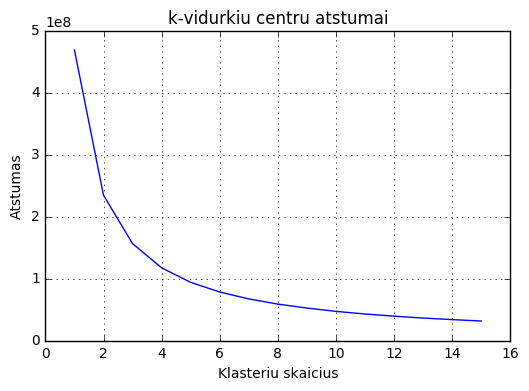

In [30]:
x=w[0:15]
y=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
   #16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

plt.plot(y, x)
plt.xlabel('Klasteriu skaicius')
plt.ylabel('Atstumas')
plt.title('k-vidurkiu centru atstumai')
plt.grid(True)
plt.savefig("kctratstumai.png")
plt.show()

Kaip galima buvo tikėtis, didžiausias taškų atstumų nuo centrų sumažėjimas pasirodo keiiant klasterių skaičių iš 1 į 2, iš ko galima būtų spręsti, kad geriausias klasterių skaičius bus 2. Tačiau pirmuoju žingsio pokyčiu negalima pasitikėi, ypač kai pokytis nėra bent keletą kartų didesnis už kitus. Daugiau didinant klasterių skaičių, taškų atstumų nuo centrų suma kinta tolygiai lėtėjančiai, iš ko nelabai daug ką galima pasakyti.

Kadangi naudojant nustatyti optimalu klasterių skaičių neišeina, galime pasirinkti WSSE pokyčių ribą, kurią pasiekus bus pasirinktas klasterių skaičius. Dėl to, kad duomenys yra pakankamai sudėtingi ir klasterius toliau apdorosime klasifikavimo algoritmu, pasirinksime 25% pokyčio ribą. Ši riba buvo pasiekta iš klasterių skaičių keičiant iš 3 į 4, taigi pasirenkame 3 klasterių klasifikavimo uždaviniui.

# Duomenų išskaidymas į klasterius

(Neveikia)

### Pagal pavyzdi

In [29]:
clusters = KMeans.train(parsedData, 3, maxIterations=10,
                        runs=10, initializationMode="k-means||")

# Save and load model
#clusters.save(sc, "3klasteriai")
#sameModel = KMeansModel.load(sc, "3klasteriai")

/opt/apache-spark/python/pyspark/mllib/clustering.py:176: UserWarning: Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.
  "Support for runs is deprecated in 1.6.0. This param will have no effect in 1.7.0.")


In [30]:
firstRow = data1.first()

In [37]:
def predictKMeans(x, centers):
    return min(
        (i for i in range(len(centers))), 
        key=lambda i: (x - centers[i]).norm(2))

def addKMeansPredictionToDataFrame(df, featuresCol, predictionCol, kMeansModelCenters):
    return (
        df.rdd
        .map(lambda r: addKMeansPredictionToRow(r, featuresCol, kMeansModelCenters))
        .toDF(df.columns + [predictionCol])
    )

def addKMeansPredictionToRow(row, featuresCol, kMeansModelCenters):
    features = row.asDict()[featuresCol]
    return row + (predictKMeans(features, kMeansModelCenters),)

In [ ]:
dfst = (
    sqlContext.read.load('std.csv',
                         format="com.databricks.spark.csv",
                         header=True, inferSchema=True, delimiter=",")
    .rdd.toDF()
).cache()

In [36]:
mllibKmeansClusteredBankDf = addKMeansPredictionToDataFrame(
    data1, 
    "features", 
    "pred_kmeans_mllib", 
    clusters.centers)

AttributeError: 'RDD' object has no attribute 'columns'

### Sukuriant atskira stulpeli

In [194]:
#padaro pipeline rdd i array rinkinio vektoriu
a=parsedData.take(100000)
#sukuria norimo dydzio nulini vektoriu. Rows skaicius is komandos DF.toPandas()
clustnr=[0]*43291
#priskiria kiekviena vektoriu klasteriui
for i in range(43291):
    clustnr[i]=clusters.predict(a[i])

In [191]:
clustnr[10100]#Eilute priskirta klasteriui:

1

In [200]:
#padaro pipeline rdd i array rinkinio vektoriu
a=parsedData.take(100000)
#sukuria norimo dydzio nulini vektoriu. Rows skaicius is komandos DF.toPandas()
clustnr=np.arange(43291)
#priskiria kiekviena vektoriu klasteriui
for i in range(43291):
    clustnr[i]=clusters.predict(a[i])

In [ ]:
Padaryti data frame stulpeli
Prijungti prie pagrindinio DF

In [ ]:
DF = sqlContext.sql("""
SELECT a.*, b.churn  
FROM DF a, DF b
WHERE a.user_account_id = b.user_account_id 
""")

In [201]:
clustnr.shape

(43291,)

In [204]:
b = clustnr.reshape(1,43291)
b.shape

(1, 43291)

In [209]:
clustnr.map(lambda l : Row(*[float(x) for x in l]))

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [207]:
df_with_clust = DF.withColumn("CLUST", clustnr)

AssertionError: col should be Column

In [127]:
from pyspark.sql.functions import lit

DF1 = DF.withColumn("CLUST", lit(0))

In [140]:
lookup = sqlContext.createDataFrame(a, (\
"user_lifetime","user_no_outgoing_activity_in_days","user_account_balance_last",
"user_spendings","reloads_inactive_days","reloads_sum,calls_outgoing_count","calls_outgoing_spendings",
"calls_outgoing_spendings_max","calls_outgoing_duration_max","calls_outgoing_inactive_days",
"calls_outgoing_to_onnet_count","calls_outgoing_to_onnet_spendings","calls_outgoing_to_onnet_duration",
"calls_outgoing_to_onnet_inactive_days","calls_outgoing_to_offnet_count,calls_outgoing_to_offnet_spendings",
"calls_outgoing_to_offnet_inactive_days","calls_outgoing_to_abroad_count","calls_outgoing_to_abroad_spendings",
"calls_outgoing_to_abroad_duration","calls_outgoing_to_abroad_inactive_days","sms_outgoing_count",
"sms_outgoing_spendings","sms_outgoing_spendings_max","sms_outgoing_inactive_days","sms_outgoing_to_onnet_count",
"sms_outgoing_to_onnet_spendings","sms_outgoing_to_onnet_inactive_days","sms_outgoing_to_offnet_count",
"sms_outgoing_to_offnet_spendings","sms_outgoing_to_abroad_count","sms_outgoing_to_abroad_spendings",
"sms_outgoing_to_abroad_inactive_days","sms_incoming_count","sms_incoming_spendings",
"sms_incoming_from_abroad_count","sms_incoming_from_abroad_spendings","gprs_session_count","gprs_usage",
"gprs_spendings,gprs_inactive_days","last_100_reloads_count","last_100_reloads_sum",
"last_100_sms_outgoing_to_abroad_count","last_100_gprs_usage"))

TypeError: Can not infer schema for type: <class 'numpy.ndarray'>

# Decision tree klasifikavimas

In [2]:
#LOAD
DF = (
    sqlContext.read.load('stdchurn.csv',
                         format="com.databricks.spark.csv",
                         header=True, inferSchema=True, delimiter=",")
    .rdd.toDF()
).cache()
DF=DF.drop('')

In [3]:
df2 = DF

vectorAssembler = VectorAssembler(inputCols=df2.drop("user_account_id").drop('churn').columns,
                                  outputCol="features")
#leave only doule num format
expr = [col(c).cast("Double").alias(c) 
        for c in vectorAssembler.getInputCols()]
df2 = DF.select(*expr)
df = vectorAssembler.transform(DF)

In [4]:
print(df)
print(DF)

DataFrame[user_account_id: bigint, user_lifetime: double, user_no_outgoing_activity_in_days: double, user_account_balance_last: double, user_spendings: double, reloads_inactive_days: double, reloads_sum: double, calls_outgoing_count: double, calls_outgoing_spendings: double, calls_outgoing_spendings_max: double, calls_outgoing_duration_max: double, calls_outgoing_inactive_days: double, calls_outgoing_to_onnet_count: double, calls_outgoing_to_onnet_spendings: double, calls_outgoing_to_onnet_duration: double, calls_outgoing_to_onnet_inactive_days: double, calls_outgoing_to_offnet_count: double, calls_outgoing_to_offnet_spendings: double, calls_outgoing_to_offnet_inactive_days: double, calls_outgoing_to_abroad_count: double, calls_outgoing_to_abroad_spendings: double, calls_outgoing_to_abroad_duration: double, calls_outgoing_to_abroad_inactive_days: double, sms_outgoing_count: double, sms_outgoing_spendings: double, sms_outgoing_spendings_max: double, sms_outgoing_inactive_days: double, s

In [5]:
    vectorAssembler = VectorAssembler(inputCols=DF.drop('churn').columns,
                                      outputCol="features")
    #leave only doule num format
    expr = [col(c).cast("Double").alias(c) 
            for c in vectorAssembler.getInputCols()]
    df2 = DF.select(*expr)
    df = vectorAssembler.transform(df2)

In [6]:
df.registerTempTable("aaa")
DF.registerTempTable("bbb")

df = sqlContext.sql("""
SELECT a.features, b.churn  
FROM aaa a, bbb b
WHERE a.user_account_id = b.user_account_id 
""")

In [7]:
df.show(10)

+--------------------+-----+
|            features|churn|
+--------------------+-----+
|[1100839.0,0.0489...|    0|
|(47,[0,1,2,5,7,11...|    1|
|(47,[0,1,2,5,7,10...|    1|
|[1106639.0,0.0446...|    0|
|(47,[0,1,2,3,4,5,...|    0|
|(47,[0,1,2,3,4,5,...|    0|
|[1120639.0,0.0324...|    1|
|[1121239.0,0.0121...|    0|
|[1121439.0,0.0147...|    0|
|[1122239.0,0.0154...|    0|
+--------------------+-----+
only showing top 10 rows



In [48]:
df.toPandas().to_csv('features_churn.csv')

In [8]:
# Load the data stored in LIBSVM format as a DataFrame.
#data = sqlContext.read.format("libsvm").load("sample_libsvm_data.txt")
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.

#labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
labelIndexer = StringIndexer(inputCol="churn", outputCol="indexedLabel").fit(df)
# Kokybiniu kintamuju tvarkymas
#featureIndexer =VectorIndexer(inputCol="features",outputCol="indexedFeatures", maxCategories=2).fit(df)

### Stratifikavimas

In [47]:
# Split the data into training and test sets (30% held out for testing)
df.describe().toPandas()

summary                churn
0   count                43291
1    mean  0.20974336467164076
2  stddev  0.40713009530341426
3     min                    0
4     max                    1

0 ir 1 churn santykis ~1:0.25. Norint ji padaryti 1:1 reikia palikti 0.25% nuliniu churn reiksniu apmokymo duomenyse.
Tada duomenis išskiriam 70:30 test ir train.

In [48]:
trainingData=df.sampleBy("churn", fractions={0: 0.25, 1: 1})
(trainingData, testData) = trainingData.randomSplit([0.7, 0.3])

In [49]:
trainingData.describe().toPandas()

summary               churn
0   count               12234
1    mean  0.5214974660781428
2  stddev  0.4995580623892966
3     min                   0
4     max                   1

In [50]:
testData.describe().toPandas()

summary               churn
0   count                5266
1    mean  0.5127231295100646
2  stddev  0.4998855615140563
3     min                   0
4     max                   1

### Decision tree modelis

In [51]:
# Train a DecisionTree model.
dt = DecisionTreeClassifier(labelCol="indexedLabel",
                            featuresCol="features")

Visi kiti galimi parametrai: https://spark.apache.org/docs/1.5.2/api/java/org/apache/spark/ml/classification/DecisionTreeClassifier.html#setImpurity(java.lang.String)

In [52]:
#Defaultiniai programos parametrai

# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, dt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("churn", "prediction", "features").show(10)

+-----+----------+--------------------+
|churn|prediction|            features|
+-----+----------+--------------------+
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
+-----+----------+--------------------+
only showing top 10 rows



In [53]:
# Select (prediction, true label) and compute test error

evaluatorprecision = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")
accuracyprecision = evaluatorprecision.evaluate(predictions)

evaluatorf1 = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
accuracyf1 = evaluatorf1.evaluate(predictions)

print("Test Error = %g " % (1.0 - accuracyprecision))
print("f1 = %g " % (1.0 - accuracyf1))

treeModel = model.stages[1]
# summary only
print(treeModel)

Test Error = 0.167869 
f1 = 0.168003 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f40beda91c5e3c6b4c0) of depth 5 with 63 nodes


In [54]:
#si funkcija neleidzia nustatyti "nodes" skaiciaus
def forest(MaxDepth):
    dt.setMaxDepth(MaxDepth)
    
    pipeline = Pipeline(stages=[labelIndexer, dt])
    model = pipeline.fit(trainingData)
    predictions = model.transform(testData)
    #predictions.select("churn", "prediction", "features").show(7)
    
    evaluatorprecision = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="precision")
    accuracyprecision = evaluatorprecision.evaluate(predictions)

    evaluatorf1 = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
    accuracyf1 = evaluatorf1.evaluate(predictions)
    
    treeModel = model.stages[1]
    print(treeModel)
    print("(Paklaida, F1 metrika) = (",1-accuracyprecision,",", 1-accuracyf1,")")
    print()
    return (1-accuracyprecision, 1-accuracyf1)

In [55]:
pkl=[0,0,0,0,0,0,0]
f1=[0,0,0,0,0,0,0]

In [56]:
for i in range(7):
    (pkl[i],f1[i])=forest(i)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f40beda91c5e3c6b4c0) of depth 0 with 1 nodes
(Paklaida, F1 metrika) = ( 0.4872768704899354 , 0.652434735205329 )

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f40beda91c5e3c6b4c0) of depth 1 with 3 nodes
(Paklaida, F1 metrika) = ( 0.17470565894417012 , 0.1749371518572863 )

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f40beda91c5e3c6b4c0) of depth 2 with 7 nodes
(Paklaida, F1 metrika) = ( 0.17470565894417012 , 0.1749371518572863 )

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f40beda91c5e3c6b4c0) of depth 3 with 15 nodes
(Paklaida, F1 metrika) = ( 0.17052791492594 , 0.17059648596177035 )

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f40beda91c5e3c6b4c0) of depth 4 with 31 nodes
(Paklaida, F1 metrika) = ( 0.16654006836308388 , 0.16658578009850544 )

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f40beda91c5e3c6b4c0) of depth 5 with 63 nodes
(Paklaida

In [59]:
dt = DecisionTreeClassifier(labelCol="indexedLabel",featuresCol="features")
#Pakeisti parametrus
dt.setMinInfoGain(0.1)

pipeline = Pipeline(stages=[labelIndexer, dt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
predictions.select("churn", "prediction", "features").show(15)
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))
treeModel = model.stages[1]
# summary only
print(treeModel)

+-----+----------+--------------------+
|churn|prediction|            features|
+-----+----------+--------------------+
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    1|       0.0|(47,[0,1,2,3,4,5,...|
|    1|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
+-----+----------+--------------------+
only showing top 15 rows

Test Error = 0.174706 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4e799863222d91ce7366) of depth 1 with 3 nodes


In [60]:
dt = DecisionTreeClassifier(labelCol="indexedLabel",featuresCol="features")
#Pakeisti parametrus
dt.setMinInstancesPerNode(2000)

pipeline = Pipeline(stages=[labelIndexer, dt])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
predictions.select("churn", "prediction", "features").show(15)
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g " % (1.0 - accuracy))
treeModel = model.stages[1]
# summary only
print(treeModel)

+-----+----------+--------------------+
|churn|prediction|            features|
+-----+----------+--------------------+
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    1|       1.0|(47,[0,1,2,5,11,1...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    1|       0.0|(47,[0,1,2,3,4,5,...|
|    1|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
|    0|       0.0|(47,[0,1,2,3,4,5,...|
+-----+----------+--------------------+
only showing top 15 rows

Test Error = 0.174706 
DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4f17ab14be7db5779de5) of depth 3 with 9 nodes


In [61]:
predictions.toPandas()

features  churn  indexedLabel  \
0     (1192239.0, 2.76877790119, 0.0504632986396, 0....      1           1.0   
1     (1192839.0, 2.76877790119, 0.0504632986396, 0....      1           1.0   
2     (1194839.0, 2.76877790119, 0.0315395616498, 0....      1           1.0   
3     (327698.0, 0.247066592675, 0.00420527488664, 0...      0           0.0   
4     (40085.0, 0.110424703402, 0.00210263744332, 0....      0           0.0   
5     (192646.0, 0.350199098683, 0.00630791232995, 0...      0           0.0   
6     (193121.0, 0.287694549587, 0.00420527488664, 0...      0           0.0   
7     (361548.0, 0.225537247986, 0.00630791232995, 0...      0           0.0   
8     (362498.0, 0.220849406804, 0.0231290118765, 2....      0           0.0   
9     (437998.0, 0.109382960917, 0.0189237369899, 0....      0           0.0   
10    (1104040.0, 0.924777953702, 0.0777975854028, 0...      1           1.0   
11    (84509.0, 0.350199098683, 0.0168210995465, 0.4...      1           1.0   
12    (90234.0, 0.350199098683, 0.00210263744332, 0....      0           0.0   
13    (150296.0, 0.349330979945, 0.00841054977327, 0...      0           0.0   
14    (416548.0, 0.14445495791, 0.0315395616498, 0.4...      0           0.0   
15    (85009.0, 0.350199098683, 0.00841054977327, 0....      0           0.0   
16    (932808.0, 0.10226438727, 0.0126158246599, 0.2...      0           0.0   
17    (317798.0, 0.232829445381, 0.0525659360829, 0....      0           0.0   
18    (401098.0, 0.0585112029033, 0.0126158246599, 2...      0           0.0   
19    (32739.0, 0.142024225445, 0.212366381775, 0.42...      1           1.0   
20    (70084.0, 0.350025474935, 0.0357448365364, 0.8...      0           0.0   
21    (21139.0, 0.188208142277, 0.0294369242064, 0.1...      0           0.0   
22    (185571.0, 0.347768366218, 0.0756949479594, 0....      1           1.0   
23    (432948.0, 0.0970556748456, 0.0567712109696, 1...      0           0.0   
24    (362698.0, 0.226058119229, 0.0168210995465, 0....      0           0.0   
25    (168396.0, 0.349851851188, 0.0126158246599, 1....      0           0.0   
26    (158621.0, 0.348115613713, 0.0210263744332, 3....      1           1.0   
27    (992608.0, 0.0154525135264, 0.0294369242064, 0...      1           1.0   
28    (116309.0, 0.345337633753, 0.0820028602894, 0....      1           1.0   
29    (935208.0, 0.098965536068, 0.0126158246599, 0....      0           0.0   
...                                                 ...    ...           ...   
5236  (1184637.0, 2.76877790119, 0.0126158246599, 0....      1           1.0   
5237  (1194437.0, 2.76877790119, 0.0504632986396, 0....      1           1.0   
5238  (1195237.0, 2.76877790119, 0.00630791232995, 0...      1           1.0   
5239  (1196837.0, 2.76877790119, 0.00630791232995, 0...      1           1.0   
5240  (1033807.0, 0.0425378181345, 0.0189237369899, ...      0           0.0   
5241  (978107.0, 0.0522607479938, 0.086208135176, 0....      1           1.0   
5242  (992107.0, 0.0182304934862, 0.00420527488664, ...      0           0.0   
5243  (1105038.0, 2.76275894461, 5.43321515353, 0.05...      1           1.0   
5244  (1177438.0, 2.76825702994, 0.0126158246599, 0....      0           0.0   
5245  (1172838.0, 0.00451421743468, 0.00630791232995...      0           0.0   
5246  (1032007.0, 0.0473992830641, 0.113542421939, 0...      1           1.0   
5247  (950407.0, 2.76339556501, 0.653920244872, 0.0,...      1           1.0   
5248  (989407.0, 2.76339556501, 0.130363521486, 0.0,...      1           1.0   
5249  (991407.0, 2.76339556501, 0.172416270352, 0.0,...      1           1.0   
5250  (1106838.0, 0.0404543331646, 0.185032095012, 0...      1           1.0   
5251  (1180238.0, 2.76877790119, 0.00630791232995, 0...      1           1.0   
5252  (1191038.0, 2.76877790119, 0.0189237369899, 0....      1           1.0   
5253  (1191238.0, 2.76877790119, 0.0504632986396, 0....      1           1.0   
5254  (1191438.0, 2.76877790119, 0.050463298639